# Formatting

In [1]:
from gensim.models import Word2Vec, KeyedVectors

# load trained vectors from hopper
y_mod = KeyedVectors.load_word2vec_format(
    'word vectors/vec3.txt', binary=True)
x_mod = KeyedVectors.load_word2vec_format(
    'word vectors/comb2.txt', binary=False)


In [19]:
x_mod.most_similar("othello")

[('iago', 0.8887432217597961),
 ('desdemona', 0.850729763507843),
 ('emilia', 0.8410863280296326),
 ('benedick', 0.7387511730194092),
 ('cassio', 0.7373813986778259),
 ('cleopatra', 0.7248365879058838),
 ('beatrice', 0.7118133306503296),
 ('iachimo', 0.6699647903442383),
 ('cressida', 0.6661145091056824),
 ('cloten', 0.6660417318344116)]

In [55]:
trnsln = {}
with open("translation_seed/train") as tr:
    for item in tr:
        item = item.rstrip().split(" ")
        trnsln[item[0]] = item[1]

test = {}
with open("translation_seed/test") as tr:
    for item in tr:
        item = item.rstrip().split(" ")
        test[item[0]] = item[1]


In [32]:
import numpy as np
# build matrices to begin SGD. Makes two matrices x and y with words from
# translation seed
vec_size_y = 100
vec_size_x = 100
num_words = len(list(trnsln.keys()))
yVals = np.zeros((num_words*vec_size_y)).reshape((num_words, vec_size_y))
xVals = np.zeros((num_words*vec_size_x)).reshape((num_words, vec_size_x))
i = 0
for key in trnsln:
    xVals[i] = x_mod[key]   # get shakespeare data
    yVals[i] = y_mod[trnsln[key]]# get modern english words of translated data from shakespeare
    i += 1

lossList = []



In [33]:
len(trnsln)

374

# Training

In [34]:
def get_gradient(x, y, A):
    grads = []
    res = np.matmul(x, A)-y

    for i in range(vec_size_x):
        for j in range(len(res)):
            grads.append(2*res[j]*x[i])

    grads = np.asarray(grads).reshape(vec_size_x, vec_size_y)
    return grads


def get_loss(vec1, vec2, A):
    return np.linalg.norm((np.matmul(vec1, A) - vec2))


def train(iters):
    global A
    for i in range(iters):
        grad = 0
        loss = 0

        for x, y in zip(xVals, yVals):
            grad += get_gradient(x, y, A)
            loss += get_loss(x, y, A)

        lossList.append(loss)
        A = A + (-1*epsilon*grad)
        if i % 10 == 0:
            print(i, lossList[-1])


In [35]:
# set hyperparamters

epsilon = .0001
lossList = []
A = np.random.rand(vec_size_x, vec_size_y)


In [36]:
train(60)

0 31449.465991773563
10 6664.817786231955
20 3560.1263124956513
30 2534.8319876837927
40 2145.1720966591165
50 1985.633931657568


# Test

In [41]:
# util functions

def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # j+1 instead of j since previous_row and current_row are one character longer
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def getLevenshtein(target, editDistanceList):
    result = []
    if len(editDistanceList) == 0:
        return result
    for i in range(len(editDistanceList)):
        output = levenshtein(target, editDistanceList[i])
        result.append(output)
    return result

def cosine_similarity(x,y):
    cosine_similarity = np.dot(x, y)/(
        np.linalg.norm(x) * np.linalg.norm(y))
    return cosine_similarity

def getPreds(key):
    results = []
    sim_res = y_mod.most_similar(positive=np.matmul(x_mod[key], A), topn=150)
    sim_res = [res[0] for res in sim_res]
    edit_dists = getLevenshtein(value, sim_res)
    for i in range(len(edit_dists)):
        if edit_dists[i] <= 2 or cosine_similarity(np.matmul(x_mod[key], A), y_mod[sim_res[i]]) > .7:
            results.append(sim_res[i])
    if len(results) == 0:
        sim_res = y_mod.most_similar(
            positive=np.matmul(x_mod[key], A), topn=5)
        sim_res = [res[0] for res in sim_res]
        return sim_res
    return results

        
        


In [42]:
# test old english specific

old_test = {}
old_test["lov'd"] = "loved"
old_test["ne'er"] = "never"
old_test["dost"] = "do"
old_test["doth"] = "does"
old_test["thyself"] = "yourself"
old_test["pleas'd"] = "pleased"
old_test["hath"] = "have"
old_test["thine"] = "yours"
old_test["exeunt"] = "exit"
old_test["speakest"] = "speak"
old_test["sayest"] = "say"

good = 0
bad = 0
print(f"Old          | Modern        | predictions")
dist = 2
for key,value in old_test.items():
    preds = getPreds(key)
    print(f"{key:<12} | {value:<12}  | {str(preds[:5]):<54} | {value in preds}")

    if value in preds:
        good+=1
    else:
        bad+=1

print(f"Correct: {good}\nIncorrect: {bad}\nAccuracy: {good/(good+bad)}")


Old          | Modern        | predictions
lov'd        | loved         | ['afraid', 'loved', 'told', 'hadn', 'wouldn']          | True
ne'er        | never         | ['never']                                              | True
dost         | do            | ['does', 'say', 'thing', 'goodness', 'shouldn']        | True
doth         | does          | ['say', 'shouldn', 'does', 'do', 'isn']                | True
thyself      | yourself      | ['yourself', 'you', 'your', 'shouldn', 'want']         | True
pleas'd      | pleased       | ['forgot', 'afraid', 'lovely', 'replied', 'pleased']   | True
hath         | have          | ['has', 'had', 'have', 'hated', 'rare']                | True
thine        | yours         | ['your', 'you', 'yourself', 'my', 'nobody']            | True
exeunt       | exit          | ['exit', 'wait', 'sit']                                | True
speakest     | speak         | ['hath', 'says', 'speaks', 'swear']                    | False
sayest       | say        

In [47]:
# raw preds

def corr(value, preds):
    if value in preds:
        return "Correct"
    else:
        return "Incorrect"


good = 0
bad = 0
print(f"Old          | Modern        | {'predictions':<54} | Accuracy")
dist = 2
correct = 0
total = 0
for key, value in test.items():
    sim_res = y_mod.most_similar(positive=np.matmul(x_mod[key], A), topn=10)
    preds = [res[0] for res in sim_res]
    if value in preds:
        correct += 1
    print(
        f"{key:<12} | {value:<12}  | {str(preds[0:5]):<54} | {corr(value,preds)}")
    total += 1
print(f"Accuracy: {correct/total:<.2f} {correct} {total}")


Old          | Modern        | predictions                                            | Accuracy
a            | a             | ['barely', 'vanity', 'reaching', 'continually', 'remarkably'] | Incorrect
i            | i             | ['myself', 'hadn', 'me', 'wouldn', 'afraid']           | Incorrect
it           | it            | ['nothing', 'says', 'thing', 'surely', 'really']       | Incorrect
but          | but           | ['therefore', 'indeed', 'moreover', 'nor', 'somehow']  | Incorrect
when         | when          | ['once', 'never', 'seemed', 'wrongly', 'faded']        | Correct
upon         | upon          | ['alarmed', 'impending', 'terror', 'imminent', 'visibly'] | Incorrect
before       | before        | ['altogether', 'despite', 'firstly', 'disappointing', 'previous'] | Incorrect
world        | world         | ['paradise', 'darkness', 'eternity', 'apocalypse', 'antichrist'] | Incorrect
most         | most          | ['regarded', 'archetype', 'popular', 'imagination', 'perhap

In [46]:
# enhanced prediction with filtering

def corr(value,preds):
    if value in preds:
        return "Correct"
    else:
        return "Incorrect"
good = 0
bad = 0
print(f"Old          | Modern        | {'predictions':<54} | Accuracy")
dist = 2
correct = 0
total = 0
for key, value in test.items():
    preds = getPreds(key)
    if value in preds:
        correct += 1
    print(
        f"{key:<12} | {value:<12}  | {str(preds[0:5]):<54} | {corr(value,preds)}")
    total += 1
print(f"Accuracy: {correct/total:<.2f} {correct} {total}")


Old          | Modern        | predictions                                            | Accuracy
a            | a             | ['up', 'had', 'no', 'sat', 'at']                       | Incorrect
i            | i             | ['myself', 'hadn', 'me', 'wouldn', 'afraid']           | Correct
it           | it            | ['we', 'my', 'it', 'me', 'apt']                        | Correct
but          | but           | ['yet', 'but', 'not', 'apt', 'oft']                    | Correct
when         | when          | ['when', 'wasn', 'he']                                 | Correct
upon         | upon          | ['alarmed', 'impending', 'terror', 'imminent', 'visibly'] | Incorrect
before       | before        | ['altogether', 'despite', 'firstly', 'disappointing', 'previous'] | Incorrect
world        | world         | ['worlds']                                             | Incorrect
most         | most          | ['most']                                               | Correct
think        | th

In [27]:
# enhanced filtering

# raw_preds = y_mod.most_similar(positive=np.matmul(x_mod[key], A), topn=150)

labels = {
    0: "I",
    1: "D",
    2: "S"
}
def levenshtein(s1, s2):
    rows = []

    # if len(s1) < len(s2):
    #     return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = list(range(len(s2) + 1))
    rows.append(previous_row)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # j+1 instead of j since previous_row and current_row are one character longer
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1   
            if c1 == c2:
                substitutions = previous_row[j] 
            else:
                substitutions = previous_row[j] + 2
            current_row.append(min(insertions, deletions, substitutions))
        rows.append(current_row)
        # ops.append(_ops)
        previous_row = current_row
    return previous_row[-1], rows

def reconstruct(mat,a,b):
    """
    s : src
    b : tgt
    """
    _a = "#"+a
    _b = "#"+b
    decisions = []

    i = len(mat) - 1  # hor
    j = len(mat[0]) - 1  # vert
    while(i > 0 or j > 0):
        prev = mat[i][j]
        # print(i,j,mat[i][j])
        insertion = deletion = substitution = 0
        if j > 0:
            insertion = mat[i-1][j]  
        if i > 0:
            deletion = mat[i][j-1]  
        if i > 0 and j > 0:
            substitution = mat[i-1][j-1]  
        temp = [insertion, deletion, substitution]
        best = labels[temp.index(min(temp))]
        if best == "I":
            if i > 0:
                i -= 1
            else:
                i = 0
            if prev != mat[i][j]:
                decisions.append(("del", _a[i+1], _a[i]))
        elif best == "D":
            if j > 0:
                j = j-1
            else:
                 j = 0
            if prev != mat[i][j]:
                decisions.append(("Ins", _b[j+1], _a[i]))
        elif best == "S":
            if i > 0:
                i -= 1
            else:
                i = 0 
            if j > 0:
                j = j-1
            else:
                j = 0
            if prev != mat[i][j]:
                decisions.append(("Sub", _a[i+1], _b[j+1]))

    decisions.reverse()
    return decisions


In [10]:
def get_edits(src,tgt):
    """
    ***Assumes src and tgt are same length***
    """
    dist, mat = levenshtein(src,tgt)
    # print(*mat, sep = "\n")
    return reconstruct(mat,src,tgt)
    

In [31]:
get_edits("bcde", "abcd")


[('Ins', 'a', '#'), ('del', 'e', 'd')]

In [6]:
def pad(src,tgt):
    if len(src) > len(tgt):
        return src, tgt.ljust(len(src),"*")
    elif len(src) < len(tgt):
        return src.ljust(len(tgt), "*"),tgt
    else:
        return src,tgt # same size


data = []
with open("translation_seed/data", encoding="utf-8") as f:
    for line in f:
        tokens = line.rstrip().replace(" ", "").split(",")
        data.append((tokens[0], tokens[1]))


In [7]:
freq_table = {} # contains (src_letter, tgt_letter, frequency)
for src,tgt in data:
    edits = get_edits(src,tgt)
    for edit in edits:
        if (edit[1], edit[2]) not in freq_table:
            freq_table[(edit[1], edit[2])] = 1
        else:
            freq_table[(edit[1], edit[2])] += 1
freq_table

{("'", '#'): 4,
 ('t', '#'): 13,
 ("'", 'e'): 17,
 ('g', '#'): 4,
 ('r', '#'): 4,
 ('f', 'o'): 1,
 ('i', 's'): 1,
 ('e', 's'): 2,
 ('k', '#'): 1,
 ('n', '#'): 5,
 ('a', 'b'): 1,
 ('v', 'o'): 1,
 ('e', 'y'): 1,
 ('u', '#'): 5,
 ('t', 's'): 3,
 ('r', 'p'): 1,
 ('i', 'p'): 1,
 ('t', 'p'): 1,
 ('h', 'l'): 1,
 ('a', 'e'): 3,
 ('s', 'e'): 1,
 ('e', 't'): 4,
 ('n', 't'): 3,
 ('m', 's'): 1,
 ('t', 'e'): 4,
 ('h', 'e'): 3,
 ('i', 'e'): 3,
 ('n', 'e'): 2,
 ('k', 'm'): 1,
 ('w', 't'): 1,
 ('a', '#'): 1,
 ('n', 's'): 1,
 ('o', 'o'): 2,
 ('s', 'd'): 3,
 ('t', 'd'): 4,
 ('o', 'u'): 1,
 ('h', '#'): 5,
 ('e', 'f'): 1,
 ('n', 'r'): 3,
 ('c', 'o'): 1,
 ('e', 'm'): 1,
 ('d', '#'): 3,
 ('o', '#'): 4,
 ('c', '#'): 4,
 ('w', 'm'): 1,
 ('r', 'e'): 4,
 ('i', 'n'): 1,
 ('e', 'o'): 3,
 ('i', 'l'): 1,
 ('g', 'r'): 1,
 ('e', 'd'): 2,
 ('e', '#'): 3,
 ('v', '#'): 2,
 ('w', 'e'): 2,
 ('i', 'r'): 1,
 ('e', 'l'): 1,
 ('s', 'l'): 2,
 ('k', 'o'): 1,
 ('y', '#'): 1,
 ('d', 'h'): 1,
 ('e', 'r'): 3,
 ("'", 'w'): 1,
 ('s',

In [223]:
import math


def get_score(a, b, freq_table):
    if(a, b) in freq_table:
        return freq_table[(a, b)]
    else:
        return 0.01


def lev(s1, s2):
    rows = []

    previous_row = [0]
    for i in range(1, len(s2)+1):
        previous_row.append(i)
    rows.append(previous_row)
    previous_row = [math.log(1)]

    for i in range(1, len(s2)+1):
        insert = rows[0][i]
        delete = previous_row[i-1]
        sub = rows[0][i-1]
        previous_row.append(min(insert, delete, sub))
        rows.append(previous_row)
    print(previous_row)
    for i in range(1, len(s1)):
        current_row = [i]
        for j in range(1, len(s2)):
            insert = get_score(s1[j], s2[i-1], freq_table) + rows[i-1][j]
            delete = get_score(s1[j-1], s2[i], freq_table) + current_row[j-1]
            sub = get_score(s1[j-1], s2[i-1], freq_table) + rows[i-1][j-1]
            current_row.append(min(insert, delete, sub))
        rows.append(current_row)

    return rows, rows[-1][-1]


print(*lev("car", "bar")[0], sep="\n")
print("-"*10)
print(*lev("car", "tar")[0], sep="\n")


[0.0, 0.0, 0.0, 0.0]
[0, 1, 2, 3]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[1, 0.01, 0.02]
[2, 0.01, 0.01]
----------
[0.0, 0.0, 0.0, 0.0]
[0, 1, 2, 3]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[1, 1, 1.01]
[2, 0.01, 0.01]


[0, 1, 2, 3]
[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 1.0986122886681098, 0.0]
[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 1.0986122886681098, 0.0]
[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 1.0986122886681098, 0.0]
[1, 0.01, 0.02]
[2, 0.01, 0.01]
[0, 1, 2, 3]
[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 1.0986122886681098, 0.0]
[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 1.0986122886681098, 0.0]
[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 1.0986122886681098, 0.0]
[1, 1, 1.01]
[2, 0.01, 0.01]


In [1]:
freq_table

NameError: name 'freq_table' is not defined

# Plotting

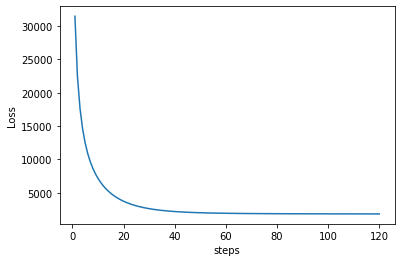

In [ ]:
import matplotlib.pyplot as plt
sz = len(lossList)
plt.plot(np.linspace(1, sz, sz), lossList[:sz])

plt.ylabel("Loss")
plt.xlabel("steps")
plt.show()

# print(lossList)



# PCA

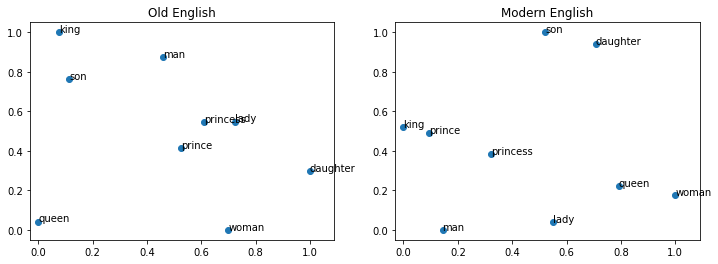

In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

from sklearn import decomposition
pca = decomposition.PCA(n_components=2)

pltDatX = []
pltDatX.append(np.matmul(A,x_mod["king"]))
pltDatX.append(np.matmul(A, x_mod["queen"]))
pltDatX.append(np.matmul(A,x_mod["man"]))
pltDatX.append(np.matmul(A,x_mod["woman"]))
pltDatX.append(np.matmul(A, x_mod["lady"]))
pltDatX.append(np.matmul(A,x_mod["prince"]))
pltDatX.append(np.matmul(A, x_mod["son"]))
pltDatX.append(np.matmul(A, x_mod["daughter"]))
pltDatX.append(np.matmul(A, x_mod["princess"]))


pltDatX = np.asarray(pltDatX)
pltDatY = []
pltDatY.append(y_mod["king"])
pltDatY.append(y_mod["queen"])
pltDatY.append(y_mod["man"])
pltDatY.append(y_mod["woman"])
pltDatY.append(y_mod["lady"])
pltDatY.append(y_mod["prince"])
pltDatY.append(y_mod["son"])
pltDatY.append(y_mod["daughter"])
pltDatY.append(y_mod["princess"])


pltDatY = np.asarray(pltDatY)

xPlt = pca.fit_transform(pltDatX)

yPlt = pca.fit_transform(pltDatY)
yPlt = scaler.fit_transform(yPlt)

lbls = ["king", "man", "queen", "woman", "lady", "prince", "son", "daughter", "princess"]

for i in range(len(xPlt)):
    xPlt[i] = rotate((0, 0), xPlt[i], 90)
xPlt = scaler.fit_transform(xPlt)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(xPlt[:, 0], xPlt[:, 1])
for i in range(len(lbls)):
    ax[0].annotate(lbls[i], xy=tuple((xPlt[i][0], xPlt[i][1])))
ax[0].set_title("Old English")
ax[0].set_xlim([-.03, 1.09])

ax[1].scatter(yPlt[:, 0], yPlt[:, 1])
for i in range(len(lbls)):
    ax[1].annotate(lbls[i], xy=tuple((yPlt[i][0], yPlt[i][1])))
ax[1].set_xlim([-.03, 1.09])
ax[1].set_title("Modern English")

plt.show()



In [ ]:
word = "you"
sims = y_mod.most_similar(word)
print(f"Modern English\nClosest Words to '{word}'")
print(f"{'Word':<10} | Cosine Similarity")
for term in sims:
    print(f"{term[0]:<10} | {term[1]}")


Modern English
Closest Words to 'you'
Word       | Cosine Similarity
your       | 0.9051563143730164
yourself   | 0.8358600735664368
want       | 0.8287676572799683
me         | 0.8240900039672852
know       | 0.8135313987731934
my         | 0.8076769709587097
think      | 0.7875840663909912
don        | 0.7871814370155334
ve         | 0.7817865610122681
sure       | 0.7751867175102234


In [ ]:
word = "thee"
sims = x_mod.most_similar(word)
print(f"Old English\nClosest Words to '{word}'")
print(f"{'Word':<10} | Cosine Similarity")
for term in sims:
    print(f"{term[0]:<10} | {term[1]}")


Old English
Closest Words to 'thee'
Word       | Cosine Similarity
me         | 0.6312958598136902
thy        | 0.608566403388977
thyself    | 0.5922002792358398
livest     | 0.5115377306938171
diest      | 0.5095685720443726
thee'      | 0.4797373414039612
oughtest   | 0.47950685024261475
mayst      | 0.4789367914199829
shouldst   | 0.4696946442127228
couldst    | 0.4601978063583374


AttributeError: 'list' object has no attribute 'shape'

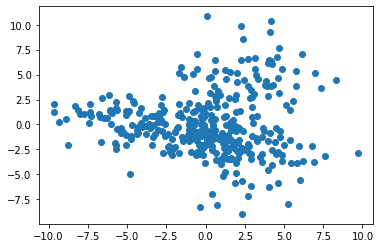

In [ ]:
from sklearn import decomposition
X = A
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(A)

pltDatX = []
pltDatY = []

pltDatX.append(x_mod["cat"])
pltDatX.append(x_mod["dog"])
pltDatX.append(x_mod["pig"])
pltDatY.append(x_mod["cat"])
pltDatY.append(x_mod["dog"])
pltDatY.append(x_mod["pig"])
lbls = ["cat", "dog", "pig"]
xPlt = pca.fit_transform(xVals)
yPlt = pca.fit_transform(yVals)
xPlt2 = pca.fit_transform(np.matmul(xVals,A))
# print(xPlt)
# xPlt[:,0]



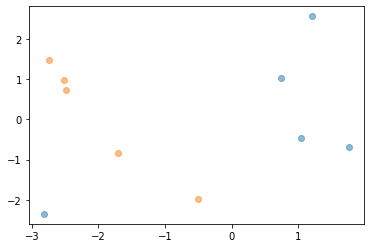

In [ ]:
x = [] #original
y = []
for i in range(5):
    x.append(xPlt[i][0])
    y.append(xPlt[i][1])

x2 = [] #y vals
y2 = []
for i in range(5):
    x2.append(yPlt[i][0])
    y2.append(yPlt[i][1])

# print(xPlt.iloc[:][0])
plt.scatter(x,y, alpha=.5)
plt.scatter(x2, y2, alpha=.5)

plt.show()
# plt.scatter(xPlt2, yPlt, alpha = .5)
# plt.show()


In [ ]:
f = open("translation_seed/data3")
dat = []
for i in range(5):
    line = f.readline()
    dat.append(line.split(",")[0].rstrip())


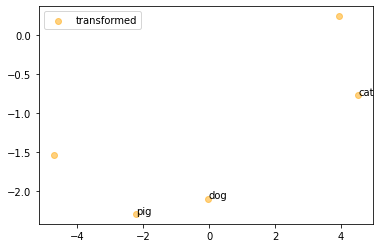

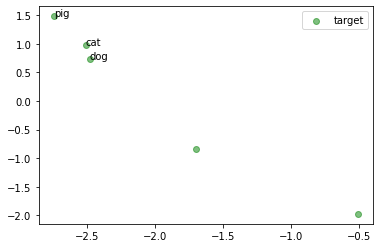

In [ ]:
x3 = []
y3 = []
for i in range(5):
    x3.append(xPlt2[i][0])
    y3.append(xPlt2[i][1])

# plt.scatter(x, y, alpha=.5, color = "red", label = "original")
plt.scatter(x3, y3, alpha=.5, color = "orange", label = "transformed")
# plt.show()
# plt.scatter(x2, y2, alpha=.5, color = "green", label = "target")

for i in range(3):
    # plt.annotate(dat[i], (x[i],y[i]))
    # plt.annotate(dat[i], (x2[i], y2[i]))
    plt.annotate(lbls[i], (x3[i], y3[i]))

plt.legend()
plt.show()

# plt.scatter(x, y, alpha=.5, color = "red", label = "original")
# plt.scatter(x3, y3, alpha=.5, color="orange", label="transformed")
# plt.show()
plt.scatter(x2, y2, alpha=.5, color = "green", label = "target")

for i in range(3):
    # plt.annotate(dat[i], (x[i],y[i]))
    plt.annotate(lbls[i], (x2[i], y2[i]))
    # plt.annotate(dat[i], (x3[i], y3[i]))

plt.legend()
plt.show()
